**SOFT DEADLINE:** `20.03.2022 23:59 msk` 

# [5 points] Part 1. Data cleaning

The task is to clear the text data of the crawled web-pages from different sites. 

It is necessary to ensure that the distribution of the 100 most frequent words includes only meaningful words in english language (not particles, conjunctions, prepositions, numbers, tags, symbols).

Determine the order of operations below and carry out the appropriate cleaning.

1. Remove non-english words
1. Remove html-tags (try to do it with regular expression, or play with beautifulsoap library)
1. Apply lemmatization / stemming
1. Remove stop-words
1. Additional processing - At your own initiative, if this helps to obtain a better distribution

#### Hints

1. To do text processing you may use nltk and re libraries
1. and / or any other libraries on your choise

#### Data reading

The dataset for this part can be downloaded here: `https://drive.google.com/file/d/1wLwo83J-ikCCZY2RAoYx8NghaSaQ-lBA/view?usp=sharing`

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive/')
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ANLP/web_sites_data.csv')

Mounted at /content/drive/


In [2]:
data.shape

(71699, 1)

#### Data processing

In [3]:
from bs4 import BeautifulSoup
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tqdm import tqdm
import numpy as np

space_regexp = re.compile(r"\s+")
nltk.download("stopwords")
nltk.download("wordnet")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [6]:
clean_data = []
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

def clean_text(text):
  soup = BeautifulSoup(text, "lxml")
  for tmp in soup(['style', 'script']):
        tmp.decompose()
  text = ' '.join(soup.stripped_strings).lower()
  text = [lemmatizer.lemmatize(w) for w in text.split() if w.isascii() and w.isalpha() and len(w) > 2 and not w in stop_words]
  return np.array(text)

for text in tqdm(data.text.values[:20000]):
  clean_data.append(clean_text(text))

clean_data = np.array(clean_data)

100%|██████████| 1000/1000 [00:57<00:00, 17.52it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


In [7]:
df = pd.DataFrame(clean_data)

In [8]:
df

,0
0,"[eric, newby, love, war, apennines, eric, newb..."
1,"[eric, newby, short, walk, hindu, kush, eric, ..."
2,"[william, wordsworth, poetry, unabridged, will..."
3,"[harriet, beecher, stowe, uncle, cabin, harrie..."
4,"[elizabeth, buchan, consider, lily, elizabeth,..."
...,...
995,"[barnes, noble, ireland, david, harpercollins,..."
996,"[barnes, noble, new, naturalist, collins, zond..."
997,"[barnes, noble, new, naturalist, lichen, olive..."
998,"[barnes, noble, lichen, oliver, zondervan, noo..."


In [ ]:
df.to_csv("/content/drive/My Drive/Colab Notebooks/ANLP/clean_data.csv",header=False)

#### Vizualization

As a visualisation, it is necessary to construct a frequency distribution of words (the 100 most common words), sorted by frequency. 

For visualization purposes we advice you to use plotly, but you are free to choose other libraries

In [ ]:
from nltk.probability import FreqDist
import numpy as np

flatten_data = [item for sublist in clean_data for item in sublist]

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(20, 15))

fd = FreqDist(flatten_data)
fd.plot(100,cumulative=False)

Let's remove first top 15 words - they are also stopwords (uncommon)

In [ ]:
top_words = [word for (word, count) in fd.most_common(15)]
flatten_data = [word for word in flatten_data if not word in top_words]

In [ ]:
figure(figsize=(20, 15))

fd = FreqDist(flatten_data)
fd.plot(100,cumulative=False)

#### Provide examples of processed text (some parts)

Is everything all right with the result of cleaning these examples? What kind of information was lost?

In [ ]:
clean_data[0]

In [ ]:
clean_data[1]

With this processing, we lose the forms of words and work only with the initial forms of words. All regular stop words and non-English words are also filtered out.

# [10 points] Part 2. Duplicates detection. LSH

#### Libraries you can use

1. LSH - https://github.com/ekzhu/datasketch
1. LSH - https://github.com/mattilyra/LSH
1. Any other library on your choise

1. Detect duplicated text (duplicates do not imply a complete word-to-word match, but texts that may contain a paraphrase, rearrangement of words, sentences)
1. Make a plot dependency of duplicates on shingle size (with fixed minhash length) 
1. Make a plot dependency of duplicates on minhash length (with fixed shingle size)

In [ ]:
!pip install datasketch

In [ ]:
from datasketch import MinHash, MinHashLSH, LeanMinHash

In [ ]:
def ngrams(doc, n):
    for i in range(len(doc)- n + 1):
      yield " ".join([t for t in doc[i:i+n]])

def unigram_shingles(doc):
    return set(doc)

def bigram_shingles(doc):
    return set(ngrams(doc, 2))

def trigram_shingles(doc):
    return set(ngrams(doc, 3))

def fourgram_shingles(doc):
    return set(ngrams(doc, 4))

def fivegram_shingles(doc):
    return set(ngrams(doc, 5))

In [ ]:
def get_minhash(shingles, num_perm=128):
    mh = MinHash(num_perm)
    for s in shingles:
        mh.update(s.encode('utf8'))
    return LeanMinHash(mh)

In [ ]:
def compute_dups(shingle_fn, num_perm=128):
    dups = set()
    mhlsh = MinHashLSH(threshold=0.8, num_perm=num_perm)

    for k, doc in tqdm(enumerate(clean_data)):
        shingles = shingle_fn(doc)
        if len(shingles) == 0:
            continue
        mh = get_minhash(shingles, num_perm)
        mhlsh.insert(k, mh)

    for k, doc in tqdm(enumerate(clean_data)):
        shingles = shingle_fn(doc)
        mh = get_minhash(shingles, num_perm)
        potentials = mhlsh.query(mh)
        for p in potentials:
            if p == k:
                continue
            dups.add((min(k,p), max(k,p)))
    return len(dups)

In [ ]:
data_for_shingle_size_plot = [compute_dups(unigram_shingles), compute_dups(bigram_shingles), compute_dups(trigram_shingles), compute_dups(fourgram_shingles), compute_dups(fivegram_shingles)]

In [ ]:
import matplotlib.pyplot as plt
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(range(1,6), data_for_shingle_size_plot)
 
plt.xlabel("Ngram size")
plt.ylabel("Detected duplication")
plt.title("Detected duplications per Ngram size")
plt.show()

In [ ]:
data_for_minhash_size_plot = [compute_dups(trigram_shingles, num_perm=32), compute_dups(trigram_shingles, num_perm=64), compute_dups(trigram_shingles, num_perm=128), compute_dups(trigram_shingles, num_perm=256), compute_dups(trigram_shingles, num_perm=512)]

In [ ]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(range(1,6), data_for_minhash_size_plot)
plt.xticks(range(1,6), [32,64,128,256,512])

plt.xlabel("MinHash length")
plt.ylabel("Detected duplication")
plt.title("Detected duplications per MinHash length")
plt.show()

# [Optional 10 points] Part 3. Topic model

In this part you will learn how to do topic modeling with common tools and assess the resulting quality of the models. 

In [13]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ANLP/data.csv', index_col="id")

In [14]:
data

,text,author
id,,
id26305,"This process, however, afforded me no means of...",EAP
id17569,It never once occurred to me that the fumbling...,HPL
id11008,"In his left hand was a gold snuff box, from wh...",EAP
id27763,How lovely is spring As we looked from Windsor...,MWS
id12958,"Finding nothing else, not even gold, the Super...",HPL
...,...,...
id17718,"I could have fancied, while I looked at it, th...",EAP
id08973,The lids clenched themselves together as if in...,EAP
id05267,"Mais il faut agir that is to say, a Frenchman ...",EAP


The provided data contain chunked stories by Edgar Allan Poe (EAP), Mary Shelley (MWS), and HP Lovecraft (HPL).

The dataset can be downloaded here: `https://drive.google.com/file/d/14tAjAzHr6UmFVFV7ABTyNHBh-dWHAaLH/view?usp=sharing`

#### Preprocess dataset with the functions from the Part 1

In [16]:
authors = data.author.values
authors

array(['EAP', 'HPL', 'EAP', ..., 'EAP', 'EAP', 'HPL'], dtype=object)

In [ ]:
processed_text = [clean_text(text) for text in data.text.values]
processed_text

#### Quality estimation

Implement the following three quality fuctions: `coherence` (or `tf-idf coherence`), `normalized PMI`, `based on the distributed word representation`(you can use pretrained w2v vectors or some other model). You are free to use any libraries (for instance gensim) and components.

In [136]:
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora

def coherence_score(topics, texts):
   cm = CoherenceModel(topics=topics, texts=texts, dictionary=corpora.Dictionary(X_train), coherence='c_v')
   return cm.get_coherence()

def nmpi_score(topics, texts):
   cm = CoherenceModel(topics=topics, texts=texts, dictionary=corpora.Dictionary(X_train), coherence='c_npmi')
   return cm.get_coherence()

### Topic modeling

Read and preprocess the dataset, divide it into train and test parts `sklearn.model_selection.train_test_split`. Test part will be used in classification part. For simplicity we do not perform cross-validation here, but you should remember about it.

In [19]:
import sklearn.model_selection

In [20]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(processed_text, authors, test_size=0.2, random_state=42)

Plot the histogram of resulting tokens counts in the processed datasets.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f994179b9d0>]],
      dtype=object)

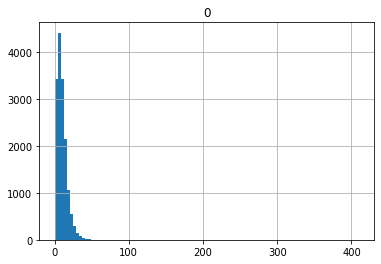

In [28]:
X_train_length = [len(token_list) for token_list in X_train]
pd.DataFrame(X_train_length).hist(bins=100)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f99415522d0>]],
      dtype=object)

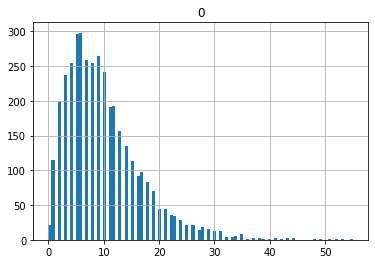

In [29]:
X_test_length = [len(token_list) for token_list in X_test]
pd.DataFrame(X_test_length).hist(bins=100)

#### NMF

Implement topic modeling with NMF (you can use `sklearn.decomposition.NMF`) and print out resulting topics. Try to change hyperparameters to better fit the dataset.

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train_uni = [" ".join(token_list) for token_list in X_train]

vectorizer = TfidfVectorizer(max_features=1500, min_df=10, stop_words='english')
vectorized_X_train = vectorizer.fit_transform(X_train_uni)
words = np.array(vectorizer.get_feature_names_out())

In [70]:
from sklearn.decomposition import NMF
model = NMF(n_components=3, init='random', random_state=0, max_iter=1000, alpha=0.1, l1_ratio=0.5)
W = model.fit_transform(vectorized_X_train)
H = model.components_

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,


In [79]:
import matplotlib.pyplot as plt

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(3,1, figsize=(7, 7), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 10})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=10)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=20)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()



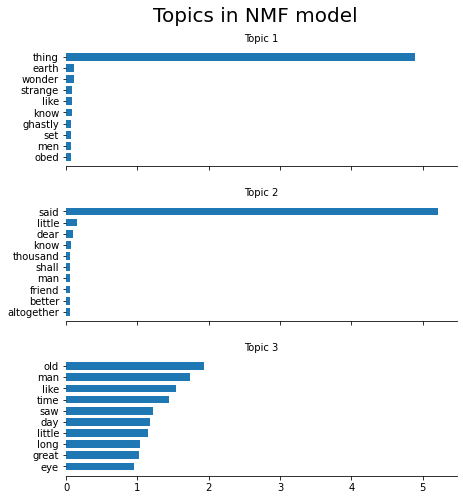

In [80]:
plot_top_words(
    model,
    words,
    10,
    "Topics in NMF model",
)

#### LDA

Implement topic modeling with LDA (you can use gensim implementation) and print out resulting topics. Try to change hyperparameters to better fit the dataset.

In [87]:
from sklearn.feature_extraction.text import CountVectorizer

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2)
tf = tf_vectorizer.fit_transform(X_train_uni)

In [88]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(
    n_components=3,
    max_iter=20,
    learning_method="online",
    learning_offset=10.0,
    random_state=0,
)

In [89]:
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', max_iter=20, n_components=3,
                          random_state=0)

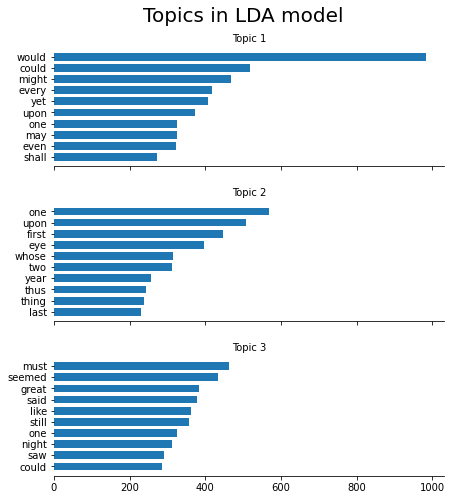

In [90]:
tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, 10, "Topics in LDA model")

### Additive regularization of topic models 

Implement topic modeling with ARTM. You may use bigartm library (simple installation for linux: pip install bigartm) or TopicNet framework (`https://github.com/machine-intelligence-laboratory/TopicNet`)

Create artm topic model fit it to the data. Try to change hyperparameters (number of specific and background topics) to better fit the dataset. Play with smoothing and sparsing coefficients (use grid), try to add decorrelator. Print out resulting topics.

In [ ]:
!pip install bigartm

In [94]:
import artm

In [122]:
cv = CountVectorizer()
n_wd = np.array(cv.fit_transform(X_train_uni).todense()).T
vocabulary = cv.get_feature_names_out()

batch_vectorizer = artm.BatchVectorizer(data_format='bow_n_wd', n_wd=n_wd, vocabulary=vocabulary)
dictionary = batch_vectorizer.dictionary


In [124]:
topic_names = ["EAP", "MWS", "HPL"]

grid = [(tau_1,tau_2) for tau_1 in [-0.5,-0.15,0.5] for tau_2 in [1.5e+6,1.5e+5,1.5e+4]]

for item in grid:
  print(item)
  model_artm = artm.ARTM(topic_names=topic_names, num_topics=3, cache_theta=True, dictionary=dictionary,
                       scores=[artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary),
                               artm.TopTokensScore(name='TopTokensScore', num_tokens=10)], 
                       regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=item[0]),
                                     artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=item[1])])
  model_artm.fit_offline(batch_vectorizer, num_collection_passes=25)
  for topic_name in model_artm.topic_names:
      print(topic_name + ': '),
      print(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])
  print()


(-0.5, 1500000.0)
EAP: 
['one', 'old', 'made', 'saw', 'first', 'two', 'time', 'would', 'found', 'thing']
MWS: 
['eye', 'could', 'like', 'would', 'still', 'one', 'seemed', 'yet', 'came', 'day']
HPL: 
['upon', 'could', 'would', 'one', 'might', 'never', 'said', 'much', 'must', 'even']

(-0.5, 150000.0)
EAP: 
['one', 'old', 'made', 'would', 'first', 'saw', 'two', 'time', 'found', 'thing']
MWS: 
['could', 'one', 'would', 'eye', 'like', 'upon', 'still', 'yet', 'seemed', 'came']
HPL: 
['upon', 'could', 'would', 'one', 'might', 'never', 'said', 'much', 'must', 'even']

(-0.5, 15000.0)
EAP: 
['one', 'old', 'made', 'would', 'first', 'saw', 'two', 'time', 'upon', 'found']
MWS: 
['could', 'one', 'would', 'eye', 'like', 'upon', 'still', 'yet', 'seemed', 'came']
HPL: 
['upon', 'could', 'would', 'one', 'might', 'never', 'said', 'much', 'must', 'even']

(-0.15, 1500000.0)
EAP: 
['one', 'old', 'first', 'saw', 'made', 'two', 'year', 'found', 'soon', 'time']
MWS: 
['still', 'like', 'eye', 'came', 'left',

In [147]:
model_artm = artm.ARTM(topic_names=topic_names, num_topics=3, cache_theta=True, dictionary=dictionary,
                       scores=[artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary),
                               artm.TopTokensScore(name='TopTokensScore', num_tokens=10)])
model_artm.fit_offline(batch_vectorizer, num_collection_passes=25)

In [148]:
model_artm_phi = artm.ARTM(topic_names=topic_names, num_topics=3, cache_theta=True, dictionary=dictionary,
                       scores=[artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary),
                               artm.TopTokensScore(name='TopTokensScore', num_tokens=10)], 
                       regularizers=[artm.SmoothSparsePhiRegularizer(name='SparsePhi')])
model_artm_phi.fit_offline(batch_vectorizer, num_collection_passes=25)

In [149]:
model_artm_phi_theta = artm.ARTM(topic_names=topic_names, num_topics=3, cache_theta=True, dictionary=dictionary,
                       scores=[artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary),
                               artm.TopTokensScore(name='TopTokensScore', num_tokens=10)], 
                       regularizers=[artm.SmoothSparsePhiRegularizer(name='SparsePhi'),
                                     artm.SmoothSparseThetaRegularizer(name='SparseTheta')])
model_artm_phi_theta.fit_offline(batch_vectorizer, num_collection_passes=25)

Write a function to convert new documents to topics probabilities vectors.

In [119]:
def doc_to_topic_prob(model_artm, text):
  cv = CountVectorizer()
  n_wd = np.array(cv.fit_transform(text).todense()).T
  vocabulary = cv.get_feature_names_out()

  batch_vectorizer = artm.BatchVectorizer(data_format='bow_n_wd', n_wd=n_wd, vocabulary=vocabulary)
  dictionary = batch_vectorizer.dictionary 
  test_theta_matrix = model_artm.transform(batch_vectorizer=batch_vectorizer)
  return test_theta_matrix

In [121]:
doc_to_topic_prob(model_artm, [X_train_uni[1]])

,0
EAP,0.313460
MWS,0.104913
HPL,0.581627


Calculate the quality scores for each model. Make a barplot to compare the quality.

In [151]:
topics1 = [model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name] for topic_name in model_artm.topic_names]

In [152]:
topics2 = [model_artm_phi.score_tracker['TopTokensScore'].last_tokens[topic_name] for topic_name in model_artm_phi.topic_names]

In [153]:
topics3 = [model_artm_phi_theta.score_tracker['TopTokensScore'].last_tokens[topic_name] for topic_name in model_artm_phi_theta.topic_names]

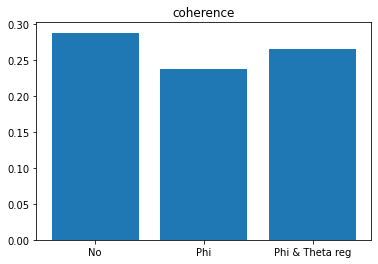

In [154]:
names = ['No', 'Phi', 'Phi & Theta reg']

plt.bar(names, [coherence_score(topics1, X_train), coherence_score(topics2, X_train), coherence_score(topics3, X_train)])
plt.title("coherence")
plt.show()